In [1]:
%pip install duckdb
%pip install seaborn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [48]:
from collections import namedtuple


TableConfig = namedtuple('Table', ['name', 'scale_factor'])
table_configs = [TableConfig('orders',1), TableConfig('customer',6)]
Table = namedtuple('Table', ['name', 'scale_factor', 'xlsx_file_path', 'result_file_path'])
tables = [Table(table.name, table.scale_factor, f'./tpch_{table.name}_sf_{table.scale_factor}.xlsx', f'./tpch_{table.name}_sf_{table.scale_factor}_results.csv')
for table in table_configs]

enable_create_tpch_xlsx = True
duckdb_executable_path = '../build/release/duckdb'
sheetreader_threads = [1,4]
runs_per_function = 5
enable_spatial_benchmarks = True

In [46]:
# %load tpch_writing.py
import duckdb

def create_tpch_xlsx(output_file_name, scale_factor=1, tpch_table_name="customer"):
    con = duckdb.connect(database = ":memory:")
    try:
        con.execute("INSTALL spatial;")
        con.execute("LOAD spatial;")
        con.execute("INSTALL tpch;")
        con.execute("LOAD tpch;")


        con.execute(f"CALL dbgen(sf = {scale_factor});")
        print(f"Created TPC-H data for scale factor {scale_factor}")

        all_cols = con.execute(f"DESCRIBE {tpch_table_name};").fetchall()

        decimal_columns = []

        for column in all_cols:
            column_name = column[0]
            column_type = column[1]

            if 'DECIMAL' in column_type:
                decimal_columns.append(column_name)

        for column in decimal_columns:
            col_name = column
            bigint_col_name = f"{col_name}_bigint"
            con.execute(f"ALTER TABLE {tpch_table_name} ADD COLUMN {bigint_col_name} BIGINT;")
            con.execute(f"UPDATE {tpch_table_name} SET {bigint_col_name} = CAST({col_name} AS BIGINT);")
            con.execute(f"ALTER TABLE {tpch_table_name} DROP COLUMN {col_name};")
            con.execute(f"ALTER TABLE {tpch_table_name} RENAME COLUMN {bigint_col_name} TO {col_name};")

        con.execute(f"COPY (SELECT * FROM {tpch_table_name}) TO '{output_file_name}' WITH (FORMAT GDAL, DRIVER 'xlsx');")

        con.close()
    except Exception as e:
        con.close()
        print(e)


In [47]:
import os
for table in tables:
  if not os.path.isfile(table.xlsx_file_path):
    create_tpch_xlsx(table.xlsx_file_path, table.scale_factor, table.name)
  else:
    print(f"Skipping creation of XLSX file for TPC-H table {table.name} with scale factor {table.scale_factor}")

Skipping creation of XLSX file for TPC-H table orders with scale factor 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created TPC-H data for scale factor 6
Catalog Error: Table with name customers does not exist!
Did you mean "customer"?


In [26]:
import timeit
import pandas as pd
import subprocess

def run_st_read(xlsx_file_path, runs_per_query=1, sheetreader_threads=[1]):
    results = pd.DataFrame(columns=['function', 'time'])

    def run(fn, fn_name):
        results.loc[len(results)] = [fn_name, timeit.timeit(fn, number=1)]
    def run_query(query):
        subprocess.run([duckdb_executable_path], input=query.encode(), stdout=subprocess.PIPE)
    def run_st_read():
        sql_stmt = f"load spatial; create table tmp_sp as from st_read('{xlsx_file_path}');"
        # Run ./duckdb_local with sql_stmt as input
        run_query(sql_stmt)
    def run_sheetreader(threads=1):
        sql_stmt = f"load sheetreader; create table tmp_sr as from sheetreader('{xlsx_file_path}', threads={threads});"
        # Run ./duckdb_local with sql_stmt as input
        return lambda : run_query(sql_stmt)

    run_query(f"install spatial;")

    for i in range(runs_per_query):
        print(f"Run {i+1}/{runs_per_query}")
        if enable_spatial_benchmarks:
            print(f"Run {i+1}/{runs_per_query} - st_read")
            run(run_st_read, 'Spatial')
        for thread in sheetreader_threads:
            print(f"Run SheetReader {i+1}/{runs_per_query} - SheetReader with {thread} threads")
            run(run_sheetreader(thread), f'SheetReader {thread} Thread{"s" if thread > 1 else ""}')

    return results


In [49]:
for table in tables:
  if not os.path.isfile(table.result_file_path):
    results = run_st_read(table.xlsx_file_path, runs_per_function, sheetreader_threads)
    results.to_csv(table.result_file_path)
  else:
    print(f"Skipping benchmark for TPC-H table {table.name} with scale factor {table.scale_factor}")


Skipping benchmark for TPC-H table orders with scale factor 1
Skipping benchmark for TPC-H table customer with scale factor 6


In [28]:
# Save dataframe to csv
import time

# results.to_csv(f"results_sf_{scale_factor}_{int(time.time())}.csv")

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_barplot(table):
  # load the results from the csv
  results = pd.read_csv(table.result_file_path)

  sns.set_style("whitegrid")


  ax = sns.barplot(
      data=results, x="function", y="time",
      errorbar=("pi", 50), capsize=.4,
      err_kws={"color": ".5", "linewidth": 2.5},
      linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
  )

  plot_title = f"Time to read XLSX file (TPH-C {table.name} Table - Scale Factor {table.scale_factor})"
  ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  ax.set(ylim=(0, max(results['time']) * 1.2))
  # Change ascpect ratio of the plot
  # ax.set_aspect(1)

  # Save the plot to a file
  plt.tight_layout()
  plt.savefig(f'boxplot_benchmark_sf_{table.scale_factor}_{"with" if enable_spatial_benchmarks else "without"}_spatial.png')
  plt.show()
  plt.clf()


def create_boxplot(table):
  ax = sns.catplot(
      data=results, x="function", y="time",
      kind="bar",
      # height=4, aspect=.5,
  )
  plot_title = f"Time to read XLSX file (TPH-C {table.name} Table - Scale Factor {table.scale_factor})"
  ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
  for axes in ax.axes.flat:
      axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")

  plt.tight_layout()
  plt.savefig(f'barplot_benchmark_sf_{table.scale_factor}_{"with" if enable_spatial_benchmarks else "without"}_spatial.png')
  plt.show()
  # Clear the plot
  plt.clf()


def joined_plot(df):
  ax = sns.catplot(
      data=df, x="table", y="time", hue="function",
      kind="bar",
      # height=4, aspect=.5,
  )
  plot_title = f"Time to read XLSX file (TPH-C Tables)"
  ax.set(xlabel='', ylabel='Time (s)', title=plot_title)
  # Remove the hue legend
  ax._legend.remove()
  plt.legend(title='Function')


  for axes in ax.axes.flat:
      axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")

  plt.tight_layout()
  plt.savefig(f'barplot_benchmark_sf_{table.scale_factor}_{"with" if enable_spatial_benchmarks else "without"}_spatial.png')
  plt.show()
  plt.clf()


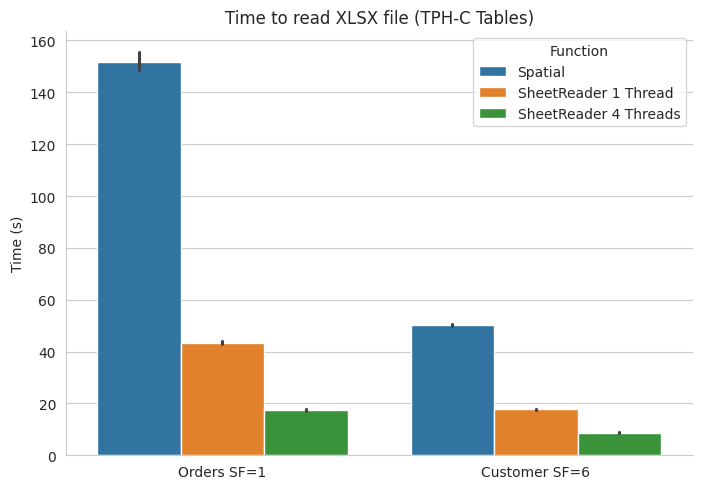

<Figure size 640x480 with 0 Axes>

In [101]:
def join_benchmarks(tables):
  joined_results = [pd.read_csv(table.result_file_path).assign(table=f"{table.name.capitalize()} SF={table.scale_factor}") for table in tables ]
  joined_results = pd.concat(joined_results)
  return joined_results

all_results = join_benchmarks(tables)
joined_plot(all_results)

/tmp/ipykernel_26084/3118922724.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")


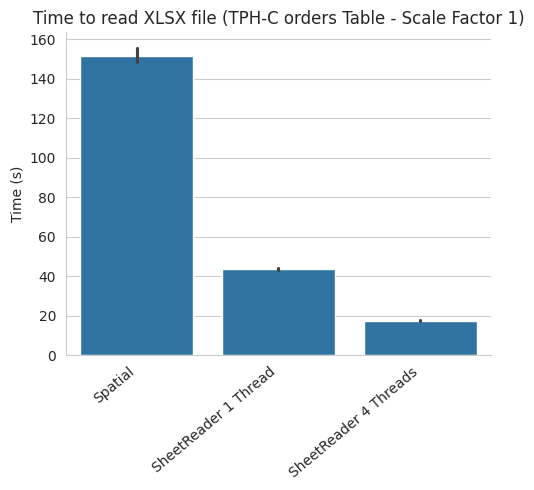

/tmp/ipykernel_26084/3118922724.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=40, ha="right")


<Figure size 640x480 with 0 Axes>

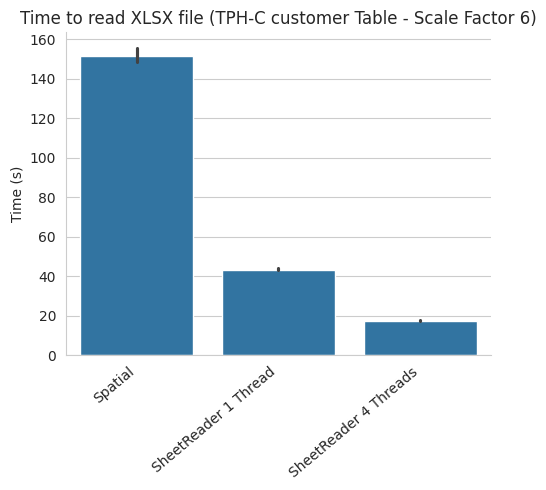

<Figure size 640x480 with 0 Axes>

In [97]:
for table in tables:
  create_boxplot(table)